# Path integrals for quantum mechanics: Part 1

The original reference here is Peter Lepage's lectures entitled *Lattice QCD for Novices*, available as [arXiv:hep-lat/0506036](https://arxiv.org/abs/hep-lat/0506036). The starting point of those lectures is one-dimensional quantum mechanics and that is where we focus our attention. The aim for Part 1 is to implement the calculations outlined by Lepage (updating some of the included Python code). In Part 2 we'll switch to using some of the standard libraries for Markov Chain Monte Carlo (MCMC) designed for Bayesian inference.

## Path integral basics

### Formal aspects

We start with a path integral representation for an imaginary-time evolution between position eigenstates in one spatial dimension:

$$
  \langle x_f | e^{-\widehat H(\tau_f - \tau_i)} | x_i \rangle = \int \mathcal{D}x(\tau)\, e^{-S[x(\tau)]}
$$ 

where $\tau = it$ and

$$
  \mathcal{D}x(\tau) \longrightarrow \mbox{sum over paths } \{x(\tau) \mbox{ where } \tau_i \leq \tau \leq \tau_f\}
  \mbox{ with } x_i = x(\tau_i),\ x_f = x(\tau_f) .
$$

The Hamiltonian is $\widehat H$ and $S[x(\tau)]$ is the classical action evaluated for path $x(\tau)$:

$$
  S[x(\tau)] \equiv \int_{\tau_i}^{\tau_f} d\tau\, L(x,\dot x; \tau)
    = \int_{\tau_i}^{\tau_f} d\tau\, \biggl[\frac{1}{2}m \dot x(\tau)^2 + V(x(\tau))\biggr] .
$$

This is the *Euclidean* version of $S$ and the Lagrangian $L$, which is why the relative sign of the kinetic and potential terms is positive (i.e., $L = T_E + V$ rather than $L = T - V$).

If we insert on the left side of the matrix element above a complete set of exact eigenstates of $\widehat H$ (labeled by $n$), namely

$$
   \mathbb{1} = \sum_n |E_n\rangle \langle E_n| 
   \quad\mbox{where}\quad \widehat H |E_n\rangle = E_n |E_n\rangle ,
$$

then we can use $e^{-\widehat H (\tau_f - \tau_i)}|E_n\rangle = e^{-E_n(\tau_f-\tau_i)}|E_n\rangle$ (which follows after a power series expansion of the exponential) to obtain

$$
  \langle x_f | e^{-\widehat H(\tau_f - \tau_i)} | x_i \rangle 
     = \sum_n \langle x_f |E_n\rangle e^{-E_n(\tau_f-\tau_i)} \langle E_n | x_i\rangle ,
$$

which involves both the wave functions and energy eigenvalues. Because $E_0 < E_{n\neq 0}$, we can take $T \equiv \tau_f - \tau_i \rightarrow \infty$ to isolate the first terms (all the others are suppressed exponentially relative to the first). We have the freedom to take $x_f = x_i \equiv x$, which yields in the large time limit:

$$
  \langle x | e^{-\widehat H T} | x \rangle \overset{T\rightarrow\infty}{\longrightarrow}
    e^{-E_0 T} |\langle x | E_0\rangle|^2 .
$$

The wavefunction $\psi_{E_0}(x) = \langle x|E_0\rangle$ is normalized, so

$$
  \int_{-\infty}^{\infty} \langle x | e^{-\widehat H T} | x \rangle \overset{T\rightarrow\infty}{\longrightarrow}
    e^{-E_0 T} 
$$    

and we get the energy (then we can go back and divide out this factor to get the wave function squared).

To derive the path integral formally, we divide up the Euclidean time interval from $\tau_i$ to $\tau_f$ into little intervals of width $\Delta \tau$ and insert a complete set of $x$ states at each time. This enables us to approximate $e^{-\widehat H\Delta\tau}$ in each interval. In a full derivation we would insert both momentum and coordinate states and evaluate the matrix element of $\widehat H(\hat p,\hat x)$. The small $\Delta\tau$ lets us neglect the commutator between $\hat p$ and $\hat x$ as higher order (proportional to $\Delta\tau^2$) If we then do all the momentum integrals, we get the path integral over $\mathcal{D}x(\tau)$. 

### Numerical implementation

In the formal discussion of path integrals, a path is defined at every continuous point in Euclidan time $\tau$, but to represent this on a computer (and actually make a sensible definition), we discretize the time:

$$  
  \tau_i \leq \tau \leq \tau_f \quad\longrightarrow\quad \tau_j = \tau_i + j a \ \mbox{for }j = 0,\ldots,N
$$

with grid (mesh) spacing $a$:

$$
   a \equiv \frac{\tau_f - \tau_i}{N} .
$$

A path is then a list of numbers:

$$
   x(\tau)\rightarrow \{x(\tau_0), x(\tau_1), \ldots, x(\tau_{N-1})\}
$$

and the integration over all paths becomes a conventional multiple integral over the values of $x_j$ at each $\tau_j$ for $1 \leq j \leq N-1$:

$$
   \int \mathcal{D}x(\tau) \longrightarrow A \int_{-\infty}^{\infty} dx_1 \int_{-\infty}^{\infty} dx_2
     \cdots \int_{-\infty}^{\infty} dx_{N-1} .
$$

The endpoints $x_0$ and $x_N$ are determined by the boundary conditions (e.g., $x_0 = x_N = x$ as used above). If we need the normalization $A$ (which we often won't because it will drop out of ratios), then for the one-dimensional problems here it is

$$
    A = \left(\frac{m}{2\pi a}\right)^{N/2} .
$$

We will need an approximation to the action. Here is one choice for $\tau_{j} \leq \tau \leq \tau_{j+1}$:

$$
  \int_{\tau_{j}}^{\tau_{j+1}} d\tau\, L \approx
    a \left[ \frac{m}{2} \left(\frac{x_{j+1}-x_{j}}{a}\right)^2 
             + \frac{1}{2} \bigl( V(x_{j+1}) + V(x_{j}) \bigr)
      \right]
$$

Now we have

$$
  \langle x | e^{-\widehat H \tau} | x \rangle \approx
    A \int_{-\infty}^{\infty} dx_1 \int_{-\infty}^{\infty} dx_2
     \cdots \int_{-\infty}^{\infty} dx_{N-1} e^{-S_{\rm lat}[x]}
$$

where

$$
   S_{\rm lat}[x] \equiv \sum_{j=0}^{N-1} 
     \left[  
      \frac{m}{2a}(x_{j+1}-x_{j})^2 + a V(x_j)
     \right]
$$

with $x_0 = x_N = x$ and $a = T/N$.

Comments:
* One might worry about the discretization of the derivatives, because of the range of the $x_{j}$'s: adjacent points can be arbitrarily far away (the paths can be arbitrarily "rough"). 

### Other matrix elements

Suppose we wanted a Euclidean expectation value:

$$
  \langle\langle x(\tau_2)x(\tau_1) \rangle\rangle
   \equiv \frac{\int \mathcal{D}x(\tau)\, x(\tau_2)x(\tau_1)\,e^{-S[x]}}{\int \mathcal{D}x(\tau)\, e^{-S[x]}}
$$

where there is an integration over $x_i = x_f = x$ as well as over the intermediate $x(t)$'s. Note that we are calculating a weighted average of $x(\tau_2)x(\tau_1)$ over all paths, where the weighting factor is $e^{-S[x]}$. This means that for every path, we take the values of $x$ at $\tau_2$ and $\tau_1$ and multiply them together, with the weight $e^{-S[x]}$ that involves the entire path.

In the continuum form, the right side is

$$
  \int dx\, \langle x| e^{-\widehat H(\tau_f-\tau_2)} \hat x e^{-\widehat H(\tau_2-\tau_1)}
    \hat x e^{-\widehat H(\tau_1-\tau_i)} | x \rangle ,
$$

so with $T = \tau_f - \tau_i$ and $\tau = \tau_2 - \tau_1$, we can insert our complete set of eigenstates to derive

$$
    \langle\langle x(\tau_2)x(\tau_1) \rangle\rangle =
    \frac{\sum_n e^{-E_n T} \langle E_n | \hat x e^{-(\widehat H-E_n)\tau}\hat x | E_n\rangle}{\sum_n e^{-E_n T}}
$$

Once again, for large $T$ the ground state will dominate the sums, so

$$
  G(\tau) \equiv \langle\langle x(\tau_2)x(\tau_1) \rangle\rangle \longrightarrow
     \langle E_0 | \hat x e^{-(\widehat H - E_0)\tau} \hat x | E_0 \rangle .
$$

But what state propagates in the middle? It could be any created by $\hat x$ acting on the ground state. But this doesn't *include* the ground state because $\hat x$ switches the parity of the state (from even to odd). We can insert a complete set of states again, and if $\tau \ll T$ is large itself, then the first excited state $|E_1\rangle$ will be projected out:

$$
  G(\tau) \overset{\tau\ {\rm large}}{\longrightarrow} |\langle E_0 | \hat x | E_1 \rangle|^2
    e^{-(E_1-E_0)\tau} .
$$

Given $G(\tau)$, we can use the $\tau$ dependence of the exponential (and $\tau$ independence of the squared matrix element) to isolate the excitation energy and then the matrix element:

$$\begin{align}
  \log(G(\tau)/G(\tau+a) &\overset{\tau\ {\rm large}}{\longrightarrow} (E_1 - E_0)a \\
  |\langle E_0 | \hat x | E_1 \rangle|^2 &\overset{\tau\ {\rm large}}{\longrightarrow} G(\tau)e^{+(E_1-E_0)\tau} 
\end{align}$$

We can, in principle, generalize to an arbitrary function of $x$, call it $\Gamma[x]$, and compute any physical property of the excited states. We can also compute thermal averages at finite $T$:

$$
  \langle\langle \Gamma[x] \rangle\rangle = 
    \frac{\sum_n e^{-E_n T} \langle E_n | \Gamma[\hat x] | E_n\rangle}{\sum_n e^{-E_n T}}
    \quad\mbox{with } T \rightarrow \beta \equiv \frac{1}{k_B T_{\rm temp}} .
$$    

### Numerical evaluation with MCMC

The idea of the Monte Carlo evaluation of

$$
 \langle\langle \Gamma[x] \rangle\rangle = 
   \frac{\int\mathcal{D}x(\tau)\, \Gamma[x]e^{-S[x]}}{\int\mathcal{D}x(\tau)\, e^{-S[x]}}
$$

is that this is a weighted average of $\Gamma[x]$ over paths, so if we generate a set of paths that are distributed according to $e^{-S[x]}$ (that is, the relative probability of a given path is proportional to this factor), then we can just do a direct average of $\Gamma[x]$ over this set.

To be explicit, we will generate a large number $N_{\rm cf}$ of random paths ("configurations" or cf)

$$
    x^{(\alpha)} \equiv \{ x_0^{(\alpha)}, x_1^{(\alpha)}, \ldots, x_{N-1}^{(\alpha)} \}
      \quad \alpha = 1,2,\ldots N_{\rm cf}
$$

on the time grid such that the probability of getting a particular path $x^{(\alpha)}$ is

$$
     P[x^{(\alpha)}] \propto e^{-S[x^{(\alpha)}]} .
$$

Then 

$$
   \langle\langle \Gamma[x] \rangle\rangle \approx \overline\Gamma \equiv
       \frac{1}{N_{\rm cf}}\sum_{\alpha=1}^{N_{\rm cf}} \Gamma[x^{(\alpha)}] .
$$

This is equivalent to approximating the probability distribution as

$$
     P[x] \approx \frac{1}{N_{\rm cf}}\sum_{\alpha=1}^{N_{\rm cf}} \delta(x - x^{(\alpha)}) . 
$$

where the delta function is the product of delta functions for each of the $x_j$'s. Note that this representation is automatically normalized simply by including the $1/N_{\rm cf}$ factor.

How good is the estimate? With a finite number of paths $N_{\rm cf}$ there is clearly a statistical error $\sigma_{\overline\Gamma}$, which he can estimate by calculating the variance using are set of paths:

$$
  \sigma_{\overline\Gamma}^2 = \frac{\langle\langle \Gamma^2 \rangle\rangle - \langle\langle  \Gamma\rangle\rangle^2}{N_{\rm cf}}
  \approx \frac{1}{N_{\rm cf}} \left\{  
      \frac{1}{N_{\rm cf}} \sum_{\alpha=1}^{N_{\rm cf}} \Gamma^2[x^{(\alpha)}] - \overline\Gamma^2
  \right\} .
$$

The numerator for large $N_{\rm cf}$ is independent of $N_{\rm cf}$ (e.g., it can be calculated directly, in principle, from quantum mechanics), so the error decreases as $\sigma_{\overline\Gamma} \propto 1/\sqrt{N_{\rm cf}}$ with increasing $N_{\rm cf}$.

We can use Markov Chain Monte Carlo (MCMC) to generate our sample of paths, first by the Metropolis algorithm and then by more sophisticated methods. Starting from an arbitrary path $x^{(0)}$, we generate a series of subsequent paths by considering each lattice site in turn, randomizing the $x_j$'s at these sites according to the algorithm, to generate a new path, and then repeat until we have $N_{\rm cf}$ random paths. The Metropolis algorithm applied to $x_j$ at the $j^{\rm th}$ site is:
* generate a random number $\zeta \sim U(-\epsilon,\epsilon)$, that is $\zeta$ is uniformly distributed from $-\zeta$ to $+\zeta$, for a constant *step size* $\epsilon$ (see later);
* replace $x_j \rightarrow x_j + \zeta$ and compute the change $\Delta S$ in the action as a result of this replacement (local Lagrangian means this only requires considering a few terms);
* if $\Delta S < 0$ (action reduced) then retain new $x_j$ and move to the next site;
* if $\Delta S > 0$, generate a random number $\eta \sim U(0,1)$ (uniform from 0 to 1) and retain the new $x_j$ if $e^{-\Delta S} > \eta$, else restore the old $x_j$; move to the next site.

Comments:
* Whether or not many of the $x_j$'s do not change in successive paths depends a lot on $\epsilon$. If $\epsilon$ is very large, then the changes in $x_j$ are large and many or most will be rejected; if $\epsilon$ is very small, then the changes in $x_j$ are small and most will be accepted, but the path will be close to the same.
* Neither situation is good: both slow down the exploration of the space of important paths.
* Claim: usually tune $\epsilon$ so 40% to 60% of the $x_j$'s change on each sweep. This implies that $\epsilon$ is the same order as the typical quantum fluctuations expected.
* Because the paths take time to get decorrelated, we should only keep every $N_{\rm cor}$ path. The optimal value can be determined empirically; here the optimal $N_{\rm cor}$ depends on $a$ as $1/a^2$.
* When starting the algorithm, the first configuration is atypical (usually). So we should have a thermalization period where the first paths are discarded. Recommendation: five to ten times $N_{\rm cor}$ should be discarded.

### Higher-order discretization

Suppose we rewrite the action for one-dimensional quantum mechanics by integrating the kinetic term by parts (assuming $x(\tau_i)=x(\tau_f)=x$:

$$
  S[x] \equiv \int_{\tau_i}^{\tau_f} d\tau\, \bigl[-\frac{1}{2}m x(\tau)\ddot x(\tau) + V(x(\tau))\bigr]
$$

The discretization is

$$
  \ddot x(t) \longrightarrow \Delta^{(2)}x_j \equiv \frac{x_{j+1}-2x_{j}+x_{j-1}}{a^2}
$$

where the $x_j$'s wrap around at the ends: $x_0 = x_{N}$, $x_{-1} = x_{N-1}$, and so on. 

## Python imports

First we import standard Python functions.

In [1]:
import numpy as np   # use np as shorthand for the numpy package
from numpy.random import uniform, normal   # two random number generators, one uniform and one Gaussian
from scipy import integrate   # import functions for integration over arrays

import matplotlib.pyplot as plt  # basic plotting package
import seaborn as sns; sns.set_style("darkgrid"); sns.set_context("talk")  # set up for better looking plots


## Classes and functions for path integrals

These are from Lepage's lectures. Not yet incorporated here.

## 1-d potential class

In [31]:
class Potential:
    """
    A general class for nonrelativistic one-dimensional potentials
    
    Parameters
    ----------
    hbar : float
        Planck's constant. Equals 1 by default
    mu : float
        Reduced mass. Equals 1 by default

    Methods
    -------
    V(x)
        Returns the value of the potential at x.
    
    E_gs
        Returns the analytic ground-state energy, if known
        
    wf_gs(x)
        Returns the analytic ground-state wave function, if known
        
    plot_V(ax, x_pts)
        Plots the potential at x_pts on ax
    """
    def __init__(self, hbar=1., mu=1., V_string=''):
        self.hbar = hbar
        self.mu = mu
        self.V_string = V_string
        print(self.hbar)
        
    def V(self, x):
        """
        Potential at x
        """
        print('The potential is not defined.') 
        
    def E_gs(self):
        """
        analytic ground state energy, if known
        """
        print('The ground state energy is not known analytically.') 
        
    def wf_gs(self, x):
        """
        analytic ground state wave function, if known
        """
        print('The ground state wave function is not known analytically.')
        
    def plot_V(self, ax, x_pts, V_label=''):
        """
        Plot the potential on the given axis
        """
        ax.plot(x_pts, self.V(x_pts), color='blue', alpha=1, label=V_label)


### Harmonic Oscillator definitions

We'll do the one-dimensional harmonic oscillator (ho), by default in units where the basic quantities are all unity.  In these units, the energies should be (n+1/2), where n = 0,1,2,3,...).  

In [5]:
class V_HO(Potential):
    """
    Harmonic oscillator potential (subclass of Potential)

    """
    def __init__(self, k_osc=1, hbar=1, mu=1, V_string='Harmonic oscillator'):
        self.k_osc = 1
        super().__init__(hbar, mu, V_string)

    def V(self, x) :
        """Standard harmonic oscillator potential for particle at x"""
        return self.k_osc * x**2 /2
    
    def E_gs(self):
        """
        1D harmonic oscillator ground-state energy
        """
        (1/2) * self.hbar * np.sqrt(self.k_osc / self.mass)  # ground state energy 
        
    def wf_gs(self, x):
        """
        1D harmonic oscillator ground-state wave function
        """
        return np.exp(-x**2 / 2) / np.pi**(1/4)  # We should  put the units back!

In [6]:
class V_aHO(Potential):
    """
    Subclass of Potential for anharmonic oscillator.

    Parameters
    ----------

    Methods
    -------

    """
    def __init__(self, k_osc=1, hbar=1, mu=1, V_string='Anharmonic oscillator'):
        self.k_osc = 1
        super().__init__(hbar, mu, V_string)

    def V(self, x) :
        """Anharmonic oscillator potential for particle at x"""
        return self.k_osc * x**4 /2


### Make some plots

In [32]:
# Instantiate a harmonic oscillator potential
mass = 1.  
k_osc = 1.  # oscillator constant 
hbar = 2. 

test_ho = V_HO(k_osc, hbar, mass)
test_aho = V_aHO(k_osc, hbar, mass)

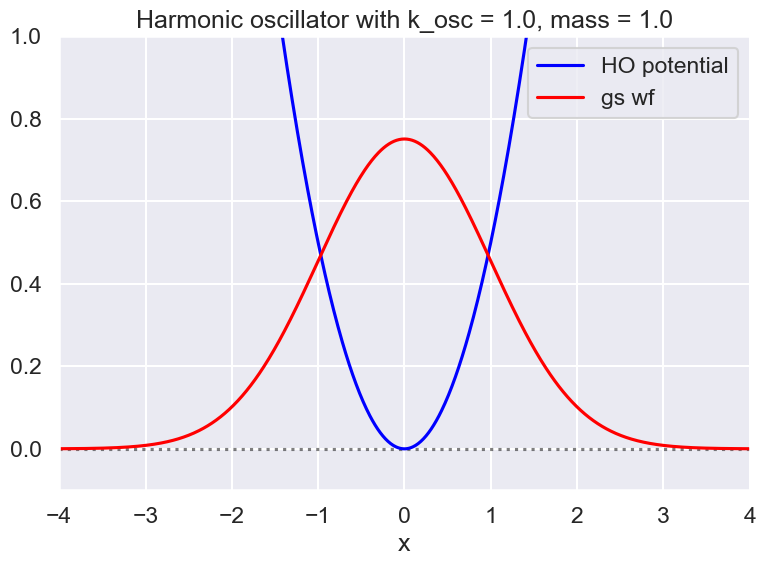

In [8]:
# Check the wave function and potential
x_pts_all = np.arange(-4., 4., .01)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'x')
#ax.set_ylabel(r'g(x)')
ax.set_xlim(-4., 4.)
ax.set_ylim(-0.1, 1.)
ax.axhline(0., color='black', alpha=0.5, linestyle='dotted')

test_ho.plot_V(ax, x_pts_all, V_label='HO potential')
ax.plot(x_pts_all, test_ho.wf_gs(x_pts_all), color='red', alpha=1, label='gs wf')

ax.set_title(f'{test_ho.V_string} with k_osc = {k_osc:.1f}, mass = {mass:.1f}')
ax.legend()
fig.tight_layout()

In [9]:
# Normalization check of wave function squared
integrate.simps(test_ho.wf_gs(x_pts_all)**2, x_pts_all)

0.9999999839221155

## Metropolis calculation (section 2.2 of Lepage lectures)

Now instead of an integration over all paths, we want to select a representative sampling of the "paths" that are distributed according to $e^{-S[x]}$.  If we succeed, we can take an unweighted average over these paths to approximate the weighted average over uniformly distributed paths.

We will use the Metropolis algorithm to generate a sequence of paths.

Define a function to initialize the first path, which is set to zero at each of the Npts times:

We update the path following the Metropolis algorithm:
1.  Step through each time point from j = 0 to Npts-1
2.  Save the value of the path at current time point j
3.  Calculate the current value of the action (only considering contributions that depend on j with speed)
4.  Generate a random number xi from -epsilon to epsilon and consider x_j --> x_j + xi
5.  Find Delta S (change in the action) for this change:  
    a. If Delta S < 0 (action reduced), keep new x_j and go to next value of j.  
    b. If Delta S > 0 (action increased), generate eta between 0 and 1. Keep new x_j if exp(-Delta S) > eta, otherwise keep old value and move on to the next j.
6.  In general we keep track of the "success" rate and adjust epsilon so that it is about 50% successes.

Define a function to do this update and print the new path at the end.

Define a function to calculate the contribution to the Hamiltonian (the energy) from time point j:

To do:
* Check for equilibration
* Check for autocorrelation
* Histogram the energy calculations and compare to the expected error

## Class for path integral

In [10]:
# Modules needed for example: emcee is for MCMCsampling, corner for plotting
from scipy import stats
#import emcee
#import corner

In [11]:
class PathIntegral:
    """
    A class for a path integral for 1D quantum mechanics. Associated with an 
    instance of the class is:
      * a potential with the Potential superclass but a particular subclass
      * a lattice definition
      * settings for correlation and thermalization "times" (Monte Carlo steps)
      * method for updating
      * method for averaging
      * list of configurations (paths)
      * choice of by-hand Metropolis updating or using emcee, zeus, or pyMC3
    
    """
    def __init__(self, Delta_T=0.25, N_pts=20, N_config=100, N_corr=20, eps=1.4,
                 V_pot=None):
        self.Delta_T = Delta_T        # DeltaT --> "a" in Lepage
        self.N_pts = N_pts            # N_pts --> "N" in Lepage 
        self.T_max = Delta_T * N_pts  # Tmax --> "T" in Lepage
        
        self.N_config = N_config
        self.N_corr = N_corr
        self.eps = eps
        
        self.V_pot = V_pot  # member of Potential class
        
        #self.x_path = np.zeros(self.N_pts)
        #self.list_of_paths = 
        
        
    def initialize(self, eps=None):
        """
        Initialize a path to zeros if eps=None otherwise to random numbers from 
        a normal distribution with mean zero and standard deviation eps.
        """
        if eps:
            x_path = np.array([normal(loc=0, scale=eps) for i in range(self.N_pts)])
        else:
            x_path = np.zeros(self.N_pts)
        return x_path

    def S_lattice(self, x_path):
        """
        Contribution to the action from path x_path 
        """
        action = 0
        for j in range(0, self.N_pts):        
            j_plus = (j + 1) % self.N_pts
            x_j = x_path[j]
            x_j_plus = x_path[j_plus]
            action = action + self.Delta_T * self.V_pot.V(x_j) \
              + (self.V_pot.mu/(2*self.Delta_T)) * (x_j_plus - x_j)**2
        return action    

    def S_lattice_j(self, x_path, j):
        """
        Function to calculate the contribution to action S from terms with j
        """
        j_plus = (j + 1) % self.N_pts  # next j point, wrapping around if needed
        j_minus = (j - 1) % self.N_pts
        x_j_minus = x_path[j_minus]
        x_j = x_path[j]
        x_j_plus = x_path[j_plus]
        
        return self.Delta_T * self.V_pot.V(x_j) \
               + self.V_pot.mu * x_j * \
                 (x_j - x_j_plus - x_j_minus) / self.Delta_T            

    def update(self, x_path):
        """
           This is a Metropolis update of the passed path.
            * x_path is an array of length N_pts
            * Step through each element and generate a candidate new value
               generated uniformly between -eps and +eps.
            * Check how much the action changes. Keep the new value *unless*
               the action increases *and* e^{-change} < uniform(0,1); that is
               even if the action increases, keep it with probability e^{-change}.    
        """
        for j in range(0, self.N_pts):
            old_x_path = x_path[j] # save original value 
            old_Sj = self.S_lattice_j(x_path, j)
            
            x_path[j] = x_path[j] + uniform(-self.eps, self.eps) # update x_path[j]
            dS = self.S_lattice_j(x_path, j) - old_Sj # change in action 
            if dS > 0 and np.exp(-dS) < uniform(0,1):
                x_path[j] = old_x_path  # restore old value
        return x_path

    def H_lattice_j(self, x_path, j):
        """
        Contribution to the energy from time point j
        """
        j_plus = (j + 1) % self.N_pts
        x_j = x_path[j]
        x_j_plus = x_path[j_plus]
        return self.Delta_T * self.V_pot.V(x_j) \
          + (self.V_pot.mu/(2*self.Delta_T)) * (x_j_plus - x_j)**2
    
    def display_x_path(self, x_path):
        """Print out x_path"""
        print(x_path)
        
    def MC_paths(self):
        """
        Accumulate paths after thermalization, skipping every N_corr
        """
        x_path = self.initialize(self.eps)  # initialize x_path 
        
        # thermalize x_path
        for i in range(5 * self.N_corr):
            x_path = self.update(x_path) 
        list_of_paths = np.array([x_path])
        
        for count in range(self.N_config-1):
            # for every count, skip N_corr paths
            for i in range(self.N_corr):
                x_path = self.update(x_path)
            # add the last one to the list
            list_of_paths = np.append(list_of_paths, [x_path], axis=0)
            
        return np.array(list_of_paths)
    
    def Gamma_avg_over_paths(self, Gamma, n, list_of_paths):
        """
        Calculate the average of Gamma(x_path, n) for tau point n over the
        paths in list_of_paths.
        """
        N_paths = len(list_of_paths)
        #print('Npaths = ', N_paths)
        Gamma_avg = 0.
        for x_path in list_of_paths:
            Gamma_avg = Gamma_avg + Gamma(x_path, n)
        return Gamma_avg / N_paths    
    
    def E_avg_over_paths(self, list_of_paths):
        """
        Average the lattice Hamiltonian over a set of configurations in
        list_of_paths.
        """
        N_paths = len(list_of_paths)
        #print('Npaths = ', N_paths)
        E_avg = 0.
        for x_path in list_of_paths:
            for j in range(N_pts):
                E_avg = E_avg + self.H_lattice_j(x_path, j)
        return E_avg / (N_paths * self.N_pts)
    
    def compute_G(self, x_path, n):
        """
        Calculate the correlator << x(t_j) x(t_{j+n}) >> averaged over 
        j = 1, ..., N_pts, where n corresponds to tau, i.e., tau = n * Delta_t.
        """
        N_tau = self.N_pts
        g = 0
        for j in range(0, N_tau):
            g = g + x_path[j] * x_path[(j+n)%N_tau] # wrap around as needed
        return g / N_tau
    
            

### Discretize time 

In [12]:
Delta_T = 0.25           # DeltaT --> "a" in Lepage
N_pts = 20               # N_pts --> "N" in Lepage 
Tmax = Delta_T * N_pts   # Tmax --> "T" in Lepage

### Set the number of configurations to generate (Nconfig) and the correlation time (Ncorr)

In [13]:
N_config = 100   # We'll want to try 25, 100, 1000, 10000 
N_corr = 20      # Lepage recommends 20 or so 
eps = 1.4  # suggested epsilon

### Set up the Metropolis procedure for the energy

Here is the basic plan:  
1. Initialize the first path to all zeros for x_j.
2. Do (5-10)*Ncorr updates to thermalize the path.  
3. Update Ncorr times, keep that path (or do the calculation of the energy with that path).
4. Repeat the last step Nconfig times.
5. Average the Nconfig values of the energy to get the estimate. 

Ok, let's set it up!  

In [14]:
# Instantiate a harmonic oscillator potential
mass = 1.  
k_osc = 1.  # oscillator constant 
hbar = 1. 

test_ho = V_HO(k_osc, hbar, mass)
test_aho = V_aHO(k_osc, hbar, mass)

In [15]:
testPI = PathIntegral(V_pot=test_ho)

In [16]:
x_path = testPI.initialize(eps=.1)
testPI.display_x_path(x_path)

[ 0.10195668  0.05010416  0.04653014 -0.05211227  0.03149327  0.05186339
  0.01102281  0.07176181 -0.09405764 -0.07931555 -0.07277317  0.02327673
  0.04835742  0.00202134 -0.18891054 -0.05090709  0.07188838  0.01121512
 -0.0219925  -0.01544483]


In [17]:
testPI.update(x_path)
testPI.display_x_path(x_path)

[ 0.10195668 -0.01767201  0.04653014  0.25418375  0.03149327 -0.14838005
  0.01102281 -0.68178282 -0.14148991  0.70981283 -0.07277317  0.02327673
 -0.13322406  0.00202134  0.10081047 -0.05090709  0.07188838  0.03152655
 -0.0219925  -0.01544483]


In [18]:
Delta_T = 0.25           # Delta_T --> "a" in Lepage
N_pts = 20               # N_pts --> "N" in Lepage 
Tmax = Delta_T * N_pts   # Tmax --> "T" in Lepage

N_config = 4000  # We'll want to try 25, 100, 1000, 10000 
N_corr = 20      # Lepage recommends 20 or so 
eps = 1.4        # suggested epsilon

new_PI = PathIntegral(Delta_T=Delta_T, N_pts=N_pts, N_config=N_config, 
                      N_corr=N_corr, eps=eps, V_pot=test_ho)

list_of_paths = new_PI.MC_paths()

#print(f'Energy = {E_mean:.5f} +/- {E_sem:.5f}')

In [19]:
print(list_of_paths.shape)
E_avg = new_PI.E_avg_over_paths(list_of_paths)
print(f'Average over {N_config} configurations is {E_avg:.5f}')


(4000, 20)
Average over 4000 configurations is 0.49917


At this point we could increase Nconfig to get a better answer or run it many times and average:

In [20]:
new_PI = PathIntegral(Delta_T=Delta_T, N_pts=N_pts, N_config=N_config, 
                      N_corr=N_corr, eps=eps, V_pot=test_ho)

list_of_paths = new_PI.MC_paths()


In [21]:
def energy_avg(N_trials, N_config_each):
    """
    Return the mean and standard deviation of N_trials of the energy
    """
    my_PI = PathIntegral(Delta_T=Delta_T, N_pts=N_pts, N_config=N_config_each, 
                      N_corr=N_corr, eps=eps, V_pot=test_ho)
    E_list = np.zeros(N_trials)
    for i in range(N_trials):
        short_list = my_PI.MC_paths()
        E_list[i] = my_PI.E_avg_over_paths(short_list)
    #print(E_list)
    E_mean = np.mean(E_list)
    E_std = np.std(E_list)
    return E_mean, E_std, E_std / np.sqrt(N_trials)

In [22]:
E_mean, E_std, E_sem = energy_avg(20, 100)
print(f'Energy = {E_mean:.5f} +/- {E_sem:.5f}')


Energy = 0.49621 +/- 0.00360


In [23]:
energy_means = []
energy_stds = []
energy_sems = []

N_trials = 100
for i in range(N_trials):
    # energy_avg()
    E_mean, E_std, E_sem = energy_avg(10, 100) # average over 10 
    #print(E_mean)
    energy_means = np.append(energy_means, E_mean)
    energy_stds = np.append(energy_stds, E_std)    
    energy_sems = np.append(energy_sems, E_sem)    

The mean of the energy means is 0.50025


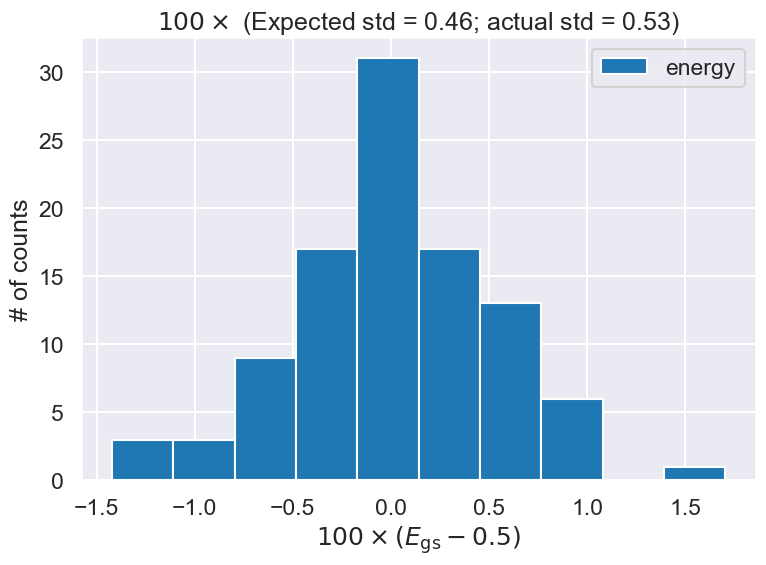

In [24]:
# Make a histogram plot of the energy and compare to expected width
expect_std = 100 * np.mean(energy_sems)
actual_std = 100 * np.std(energy_means)

mean_of_means = np.mean(energy_means)
print(f'The mean of the energy means is {mean_of_means:.5f}')

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'$100 \times (E_{\rm gs} - 0.5) $')
ax.set_ylabel(r'# of counts')
ax.set_title(fr'$100 \times$ (Expected std = {expect_std:.2f}; actual std = {actual_std:.2f})')

ax.hist(100*(energy_means - 0.5), bins=10, density=False, label='energy')

# ax.axhline(0., color='black', alpha=0.5, linestyle='dotted')
# ax.plot(x_pts_all, V_HO(x_pts_all), color='blue', alpha=1, label='HO potential')
# ax.plot(x_pts_all, HO_gs_wf(x_pts_all), color='red', alpha=1, label='gs wf')
# ax.set_title(f'Harmonic oscillator with k_osc = {k_osc:.1f}, mass = {mass:.1f}')

ax.legend()
fig.tight_layout()

### Trying a larger lattice spacing a

In [25]:
Delta_T = 0.50           # Delta_T --> "a" in Lepage
N_pts = 20               # N_pts --> "N" in Lepage 
Tmax = Delta_T * N_pts   # Tmax --> "T" in Lepage

N_config = 4000  # We'll want to try 25, 100, 1000, 10000 
N_corr = 20      # Lepage recommends 20 or so 
eps = 1.4        # suggested epsilon

new_PI = PathIntegral(Delta_T=Delta_T, N_pts=N_pts, N_config=N_config, 
                      N_corr=N_corr, eps=eps, V_pot=test_ho)


In [26]:
list_of_paths = new_PI.MC_paths()

print(list_of_paths.shape)
E_avg = new_PI.E_avg_over_paths(list_of_paths)
print(f'Average over {N_config} configurations is {E_avg:.5f}')


(4000, 20)
Average over 4000 configurations is 0.50167


In [27]:
E_avg_test = np.array([new_PI.Gamma_avg_over_paths(new_PI.H_lattice_j, n, list_of_paths) for n in range(N_pts)])
    
print(f'Average over {N_config} configurations at each n: ', E_avg_test)

print(f'\nMean: {np.mean(E_avg_test):.5f} +/- {np.std(E_avg_test)/np.sqrt(N_pts):.5f}')

Average over 4000 configurations at each n:  [0.49433438 0.4832704  0.48650586 0.49654364 0.50041304 0.51124005
 0.50215313 0.50662874 0.48644347 0.50765943 0.49763309 0.50666532
 0.50328084 0.50794191 0.51104406 0.51488762 0.51574784 0.51479515
 0.49457307 0.49173305]

Mean: 0.50167 +/- 0.00218


In [28]:
g_avg_test = np.array([new_PI.Gamma_avg_over_paths(new_PI.compute_G, n, list_of_paths) for n in range(N_pts)])

print(g_avg_test)

[0.49129453 0.30186899 0.18678105 0.11679738 0.07323281 0.04563235
 0.02714714 0.01569043 0.0094236  0.00836482 0.008407   0.00836482
 0.0094236  0.01569043 0.02714714 0.04563235 0.07323281 0.11679738
 0.18678105 0.30186899]


In [29]:
DeltaE = np.array([np.log(g_avg_test[n] / g_avg_test[n+1]) / Delta_T for n in range(N_pts-1)])
print(DeltaE)

[ 0.97410137  0.96011211  0.9389928   0.9335943   0.94605323  1.03869034
  1.09644204  1.01966629  0.23836496 -0.01006005  0.01006005 -0.23836496
 -1.01966629 -1.09644204 -1.03869034 -0.94605323 -0.9335943  -0.9389928
 -0.96011211]


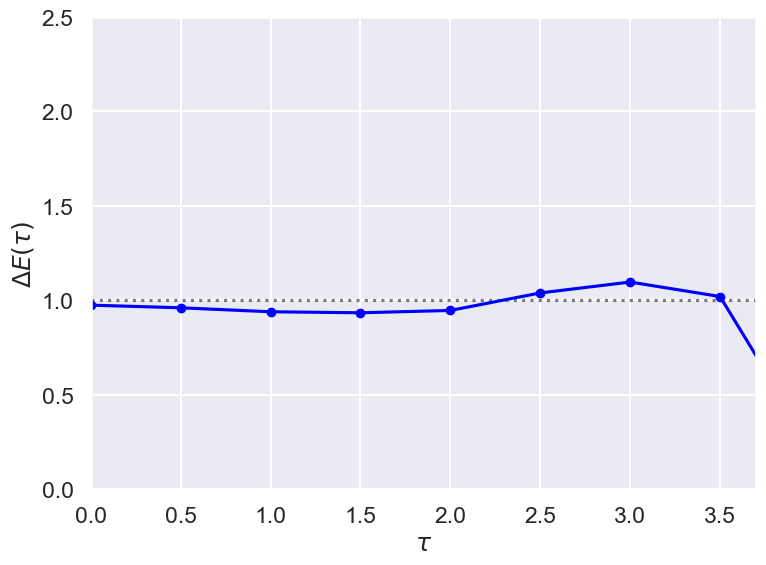

In [30]:
# Check the wave function and potential
t_pts_all = np.arange(0, (N_pts-1)*Delta_T, Delta_T)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\Delta E(\tau)$')
ax.set_xlim(0,3.7)
ax.set_ylim(0, 2.5)
ax.axhline(1., color='black', alpha=0.5, linestyle='dotted')

ax.plot(t_pts_all, DeltaE, color='blue', alpha=1, marker='o', markersize=6)
#ax.legend()
fig.tight_layout()